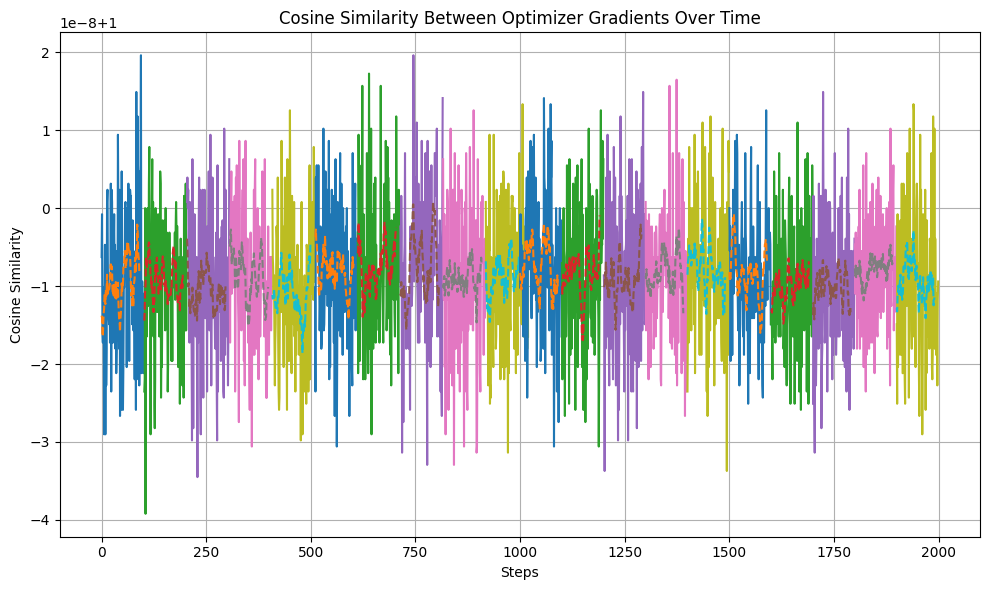

In [3]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer, AdamW
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F  # For cosine similarity calculation

# Configuration dictionary
cfg = {
    "model_name": "EleutherAI/pythia-70m",  # Updated to pythia-70m
    "learning_rate": 1e-4,
    "training_batch_size": 1,
    "inference_batch_size": 200,  # Inference batch size set to 200
    "num_train_epochs": 1,
    "max_length": 128,
    "repeat_loops": 10,  # Updated to 10 repeat loops
    "experiment_name": "loop_training_experiment_2",
    "qa_data_file": "/workspace/slice-monorepo/sub_validations/episodic_memory_paper/qa_data.json",
    "pile_data_file": "/workspace/slice-monorepo/sub_validations/unique_seq_sentence/detokenized_output.json",
    "inference_params": {
        "max_new_tokens": 50,
        "temperature": 0.7,
        "top_k": 50,
        "do_sample": True,
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Create experiment folder
def create_experiment_folder(cfg):
    experiment_folder = f"experiments/{cfg['experiment_name']}"
    os.makedirs(experiment_folder, exist_ok=True)
    return experiment_folder

# Batch saving of CSV data using Pandas
class CSVLogger:
    def __init__(self, file_path, columns):
        self.file_path = file_path
        self.columns = columns
        self.buffer = []

    def log(self, row):
        self.buffer.append(row)

    def flush(self):
        if self.buffer:
            df = pd.DataFrame(self.buffer, columns=self.columns)
            if not os.path.exists(self.file_path):
                df.to_csv(self.file_path, mode='w', header=True, index=False)
            else:
                df.to_csv(self.file_path, mode='a', header=False, index=False)
            self.buffer = []

# Save the configuration to the experiment folder
def save_config(cfg, experiment_folder):
    config_path = os.path.join(experiment_folder, "config.json")
    with open(config_path, 'w') as config_file:
        json.dump(cfg, config_file, indent=4)

# Loop class to store loop data
class Loop:
    def __init__(self, loop_id, pile_data, qa_data, optimizer_state=None):
        self.loop_id = loop_id
        self.pile_data = pile_data  # List of texts
        self.qa_data = qa_data  # {'question', 'answer'}
        self.optimizer_state = optimizer_state  # Optimizer state dict

# Custom Dataset for Loop data
class LoopDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts  # List of texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokenized = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': tokenized['input_ids'].squeeze(),
            'attention_mask': tokenized['attention_mask'].squeeze(),
            'labels': tokenized['input_ids'].squeeze()
        }

class Trainer:
    def __init__(self, cfg, tokenizer, model, experiment_folder):
        self.cfg = cfg
        self.tokenizer = tokenizer
        self.device = cfg['device']
        self.model = model.to(self.device)
        self.experiment_folder = experiment_folder

        self.training_loss_logger = CSVLogger(
            os.path.join(experiment_folder, "training_loss.csv"),
            ["Training Loop ID", "Loop Repeat", "Step", "Loss"]
        )
        self.inference_results_logger = CSVLogger(
            os.path.join(experiment_folder, "inference_results.csv"),
            ["Loop ID", "Step", "Question", "Answer", "Correct", "Raw Output", "Inference Identifier"]
        )

        # Track cosine similarities
        self.cosine_similarities = []

    def compute_cosine_similarity(self, optimizer1, optimizer2):
        grads1 = [param.grad for param in optimizer1.param_groups[0]['params'] if param.grad is not None]
        grads2 = [param.grad for param in optimizer2.param_groups[0]['params'] if param.grad is not None]

        cos_sims = []
        for g1_param, g2_param in zip(grads1, grads2):
            # Flatten the gradients and compute cosine similarity using torch's built-in method
            g1_flat = g1_param.view(-1)
            g2_flat = g2_param.view(-1)
            cos_sim = F.cosine_similarity(g1_flat, g2_flat, dim=0).item()
            cos_sims.append(cos_sim)
        
        avg_cos_sim = np.mean(cos_sims)
        return avg_cos_sim

    def running_average(self, data, window_size=10):
        """Compute running average using convolution."""
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    def plot_cosine_similarity(self):
        plt.figure(figsize=(10, 6))

        concatenated_steps = []
        for loop_id, similarities in enumerate(self.cosine_similarities):
            # Adjust the steps so that each loop follows the previous one
            step_range = list(range(loop_id * len(similarities), (loop_id + 1) * len(similarities)))
            concatenated_steps.extend(step_range)

            plt.plot(step_range, similarities)

            # Add running average for each loop
            running_avg = self.running_average(similarities)
            plt.plot(step_range[:len(running_avg)], running_avg, linestyle='--')

        plt.xlabel('Steps')
        plt.ylabel('Cosine Similarity')
        plt.title('Cosine Similarity Between Optimizer Gradients Over Time')

        # No y-axis limits (dynamic range)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.experiment_folder, 'cosine_similarity_plot.png'))
        plt.show()

    def train_loop(self, loop, other_loop, loop_repeat, train_on_qa):
        optimizer1 = AdamW(self.model.parameters(), lr=self.cfg['learning_rate'])
        optimizer2 = AdamW(self.model.parameters(), lr=self.cfg['learning_rate'])

        if loop.optimizer_state is not None:
            optimizer1.load_state_dict(loop.optimizer_state)

        # Prepare loop's own QA data
        n = len(loop.pile_data)
        insert_index = n // 3
        qa_text = f"Q: {loop.qa_data['question']} A: {loop.qa_data['answer']}"
        loop_data_texts = loop.pile_data.copy()

        if train_on_qa:
            bad_qa_question = other_loop.qa_data['question']
            bad_qa_answer = loop.qa_data['answer']
            bad_qa_text = f"Q: {bad_qa_question} A: {bad_qa_answer}"
            loop_data_texts.insert(insert_index, bad_qa_text)
            loop_data_texts.insert(insert_index + 1, qa_text)

        dataset = LoopDataset(loop_data_texts, self.tokenizer, max_length=self.cfg['max_length'])
        dataloader = DataLoader(dataset, batch_size=self.cfg['training_batch_size'], shuffle=False)

        steps = 0
        cosine_similarities_loop = []

        self.model.train()
        for epoch in range(self.cfg['num_train_epochs']):
            for step_idx, batch in enumerate(dataloader, start=1):
                optimizer1.zero_grad()
                optimizer2.zero_grad()

                inputs = {key: val.to(self.device) for key, val in batch.items()}
                outputs = self.model(**inputs)
                loss = outputs.loss
                loss.backward()
                optimizer1.step()
                optimizer2.step()

                # Compute cosine similarity between gradients of both optimizers
                cos_sim = self.compute_cosine_similarity(optimizer1, optimizer2)
                cosine_similarities_loop.append(cos_sim)

                steps += 1
                self.training_loss_logger.log([loop.loop_id, loop_repeat + 1, steps, loss.item()])

        loop.optimizer_state = optimizer1.state_dict()
        self.cosine_similarities.append(cosine_similarities_loop)
        self.training_loss_logger.flush()
        self.inference_results_logger.flush()

def main():
    tokenizer = AutoTokenizer.from_pretrained(cfg['model_name'])
    tokenizer.padding_side = 'left'  # Set padding side to left for decoder-only architecture

    model = GPTNeoXForCausalLM.from_pretrained(
        cfg['model_name'],
        pad_token_id=tokenizer.eos_token_id
    )
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))

    with open(cfg['qa_data_file'], 'r') as f:
        qa_data_json = json.load(f)

    with open(cfg['pile_data_file'], 'r') as f:
        pile_data = json.load(f)

    loops = []
    for loop_id in range(2):
        pile_start = loop_id * 100
        pile_end = pile_start + 100
        pile_data_loop = pile_data[pile_start:pile_end]

        qa_question = qa_data_json['qa_data']['question'][loop_id]
        qa_answer = qa_data_json['qa_data']['answer'][loop_id]
        qa_data = {'question': qa_question, 'answer': qa_answer}

        loop = Loop(loop_id, pile_data_loop, qa_data)
        loops.append(loop)

    experiment_folder = create_experiment_folder(cfg)
    save_config(cfg, experiment_folder)

    trainer = Trainer(cfg, tokenizer, model, experiment_folder)

    for repeat_idx in range(cfg['repeat_loops']):
        train_on_qa = repeat_idx < (cfg['repeat_loops'] // 2)

        for i in range(len(loops)):
            current_loop = loops[i]
            other_loop = loops[1 - i]
            trainer.train_loop(current_loop, other_loop, repeat_idx, train_on_qa)

    trainer.plot_cosine_similarity()

if __name__ == "__main__":
    main()


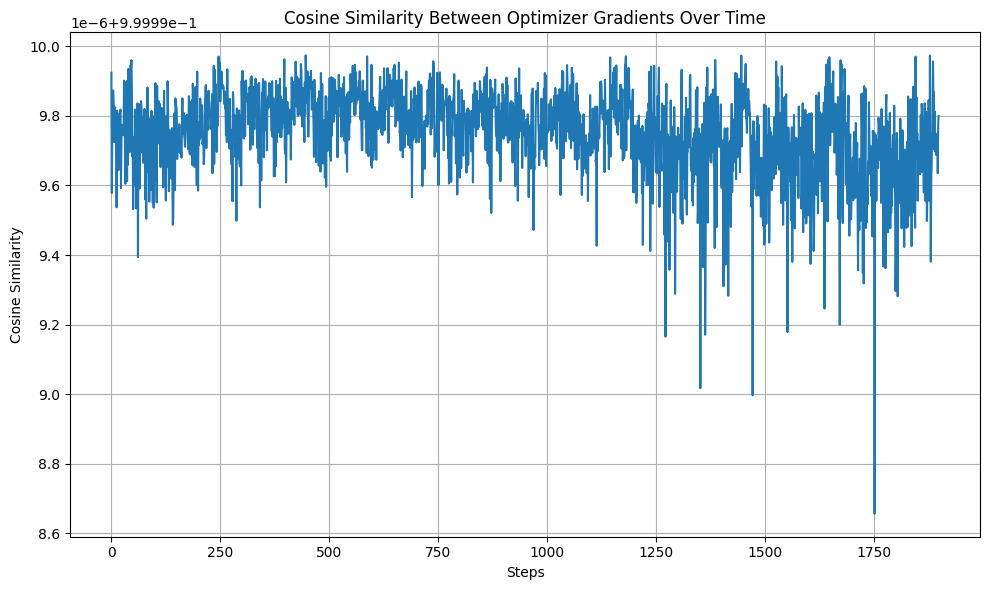

In [8]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer, AdamW
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F  # For cosine similarity calculation

# Configuration dictionary
cfg = {
    "model_name": "EleutherAI/pythia-70m",  # Using pythia-70m
    "learning_rate": 1e-4,
    "training_batch_size": 1,
    "inference_batch_size": 200,
    "num_train_epochs": 1,
    "max_length": 128,
    "repeat_loops": 10,  # 10 repeat loops
    "experiment_name": "loop_training_experiment_cosine",
    "qa_data_file": "/workspace/slice-monorepo/sub_validations/episodic_memory_paper/qa_data.json",
    "pile_data_file": "/workspace/slice-monorepo/sub_validations/unique_seq_sentence/detokenized_output.json",
    "inference_params": {
        "max_new_tokens": 50,
        "temperature": 0.7,
        "top_k": 50,
        "do_sample": True,
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Create experiment folder
def create_experiment_folder(cfg):
    experiment_folder = f"experiments/{cfg['experiment_name']}"
    os.makedirs(experiment_folder, exist_ok=True)
    return experiment_folder

# Batch saving of CSV data using Pandas
class CSVLogger:
    def __init__(self, file_path, columns):
        self.file_path = file_path
        self.columns = columns
        self.buffer = []

    def log(self, row):
        self.buffer.append(row)

    def flush(self):
        if self.buffer:
            df = pd.DataFrame(self.buffer, columns=self.columns)
            if not os.path.exists(self.file_path):
                df.to_csv(self.file_path, mode='w', header=True, index=False)
            else:
                df.to_csv(self.file_path, mode='a', header=False, index=False)
            self.buffer = []

# Save the configuration to the experiment folder
def save_config(cfg, experiment_folder):
    config_path = os.path.join(experiment_folder, "config.json")
    with open(config_path, 'w') as config_file:
        json.dump(cfg, config_file, indent=4)

# Loop class to store loop data
class Loop:
    def __init__(self, loop_id, pile_data, qa_data, optimizer_state=None):
        self.loop_id = loop_id
        self.pile_data = pile_data  # List of texts
        self.qa_data = qa_data  # {'question', 'answer'}
        self.optimizer_state = optimizer_state  # Optimizer state dict

# Custom Dataset for Loop data
class LoopDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts  # List of texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokenized = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': tokenized['input_ids'].squeeze(),
            'attention_mask': tokenized['attention_mask'].squeeze(),
            'labels': tokenized['input_ids'].squeeze()
        }

class Trainer:
    def __init__(self, cfg, tokenizer, model, experiment_folder):
        self.cfg = cfg
        self.tokenizer = tokenizer
        self.device = cfg['device']
        self.model = model.to(self.device)
        self.experiment_folder = experiment_folder

        self.training_loss_logger = CSVLogger(
            os.path.join(experiment_folder, "training_loss.csv"),
            ["Training Loop ID", "Loop Repeat", "Step", "Loss"]
        )
        self.inference_results_logger = CSVLogger(
            os.path.join(experiment_folder, "inference_results.csv"),
            ["Loop ID", "Step", "Question", "Answer", "Correct", "Raw Output", "Inference Identifier"]
        )

        # Track cosine similarities
        self.cosine_similarities = []
        self.previous_optimizer_state = None  # To store the previous optimizer state

    def compute_cosine_similarity(self, optimizer1, optimizer2):
        """Compute the cosine similarity between gradients of two optimizers."""
        grads1 = [param.grad for param in optimizer1.param_groups[0]['params'] if param.grad is not None]
        grads2 = [param.grad for param in optimizer2.param_groups[0]['params'] if param.grad is not None]

        cos_sims = []
        epsilon = 1e-8  # Small epsilon to avoid division by zero
        for g1_param, g2_param in zip(grads1, grads2):
            g1_flat = g1_param.view(-1)
            g2_flat = g2_param.view(-1)

            # Compute cosine similarity, adding epsilon for numerical stability
            denom = (g1_flat.norm() * g2_flat.norm()) + epsilon
            if denom > 0:
                cos_sim = torch.dot(g1_flat, g2_flat) / denom
                cos_sim = torch.clamp(cos_sim, -1.0, 1.0)  # Clamp to valid range [-1, 1]
            else:
                cos_sim = torch.tensor(0.0, device=self.device)

            cos_sims.append(cos_sim.item())

        avg_cos_sim = np.mean(cos_sims)
        return avg_cos_sim

    def plot_cosine_similarity(self):
        """Plot cosine similarity after training is complete."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.cosine_similarities)
        plt.xlabel('Steps')
        plt.ylabel('Cosine Similarity')
        plt.title('Cosine Similarity Between Optimizer Gradients Over Time')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(self.experiment_folder, 'cosine_similarity_plot.png'))
        plt.show()

    def train_loop(self, loop, other_loop, loop_repeat, train_on_qa):
        """Train a loop and compare the optimizer's gradient similarity to the previous loop."""
        optimizer1 = AdamW(self.model.parameters(), lr=self.cfg['learning_rate'])

        if loop.optimizer_state is not None:
            optimizer1.load_state_dict(loop.optimizer_state)

        dataset = LoopDataset(loop.pile_data, self.tokenizer, max_length=self.cfg['max_length'])
        dataloader = DataLoader(dataset, batch_size=self.cfg['training_batch_size'], shuffle=False)

        steps = 0
        cosine_similarities_loop = []

        self.model.train()
        for epoch in range(self.cfg['num_train_epochs']):
            for step_idx, batch in enumerate(dataloader, start=1):
                optimizer1.zero_grad()

                inputs = {key: val.to(self.device) for key, val in batch.items()}
                outputs = self.model(**inputs)
                loss = outputs.loss
                loss.backward()
                optimizer1.step()

                # Compare current optimizer state with the previous optimizer state
                if self.previous_optimizer_state is not None:
                    optimizer2 = AdamW(self.model.parameters(), lr=self.cfg['learning_rate'])
                    optimizer2.load_state_dict(self.previous_optimizer_state)
                    cos_sim = self.compute_cosine_similarity(optimizer1, optimizer2)
                    cosine_similarities_loop.append(cos_sim)

                steps += 1
                self.training_loss_logger.log([loop.loop_id, loop_repeat + 1, steps, loss.item()])

        # Save the current optimizer state for future comparison
        loop.optimizer_state = optimizer1.state_dict()
        self.previous_optimizer_state = optimizer1.state_dict()  # Save for the next loop

        self.cosine_similarities.extend(cosine_similarities_loop)
        self.training_loss_logger.flush()
        self.inference_results_logger.flush()

def main():
    tokenizer = AutoTokenizer.from_pretrained(cfg['model_name'])
    tokenizer.padding_side = 'left'  # Set padding side to left for decoder-only architecture

    model = GPTNeoXForCausalLM.from_pretrained(
        cfg['model_name'],
        pad_token_id=tokenizer.eos_token_id
    )
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))

    with open(cfg['qa_data_file'], 'r') as f:
        qa_data_json = json.load(f)

    with open(cfg['pile_data_file'], 'r') as f:
        pile_data = json.load(f)

    loops = []
    for loop_id in range(2):
        pile_start = loop_id * 100
        pile_end = pile_start + 100
        pile_data_loop = pile_data[pile_start:pile_end]

        qa_question = qa_data_json['qa_data']['question'][loop_id]
        qa_answer = qa_data_json['qa_data']['answer'][loop_id]
        qa_data = {'question': qa_question, 'answer': qa_answer}

        loop = Loop(loop_id, pile_data_loop, qa_data)
        loops.append(loop)

    experiment_folder = create_experiment_folder(cfg)
    save_config(cfg, experiment_folder)

    trainer = Trainer(cfg, tokenizer, model, experiment_folder)

    # Start with no similarity in the first loop
    for repeat_idx in range(cfg['repeat_loops']):
        train_on_qa = repeat_idx < (cfg['repeat_loops'] // 2)

        for i in range(len(loops)):
            current_loop = loops[i]
            other_loop = loops[1 - i]  # The other loop
            trainer.train_loop(current_loop, other_loop, repeat_idx, train_on_qa)

    trainer.plot_cosine_similarity()

if __name__ == "__main__":
    main()


Cosine similarity at start of loop 1: 0.9999999984314567
Cosine similarity at start of loop 0: 0.9999999905887403
Cosine similarity at start of loop 1: 0.9999999921572836
Cosine similarity at start of loop 0: 1.0000000070584447
Cosine similarity at start of loop 1: 0.9999999968629134
Cosine similarity at start of loop 0: 0.9999999898044687
Cosine similarity at start of loop 1: 0.9999999945100985
Cosine similarity at start of loop 0: 0.9999999827460239
Cosine similarity at start of loop 1: 0.9999999984314567
Cosine similarity at start of loop 0: 0.999999991373012
Cosine similarity at start of loop 1: 0.9999999960786418
Cosine similarity at start of loop 0: 1.0000000156854327
Cosine similarity at start of loop 1: 0.9999999898044687
Cosine similarity at start of loop 0: 0.9999999843145672
Cosine similarity at start of loop 1: 0.9999999843145672
Cosine similarity at start of loop 0: 1.0000000070584447
Cosine similarity at start of loop 1: 0.9999999929415552
Cosine similarity at start of lo

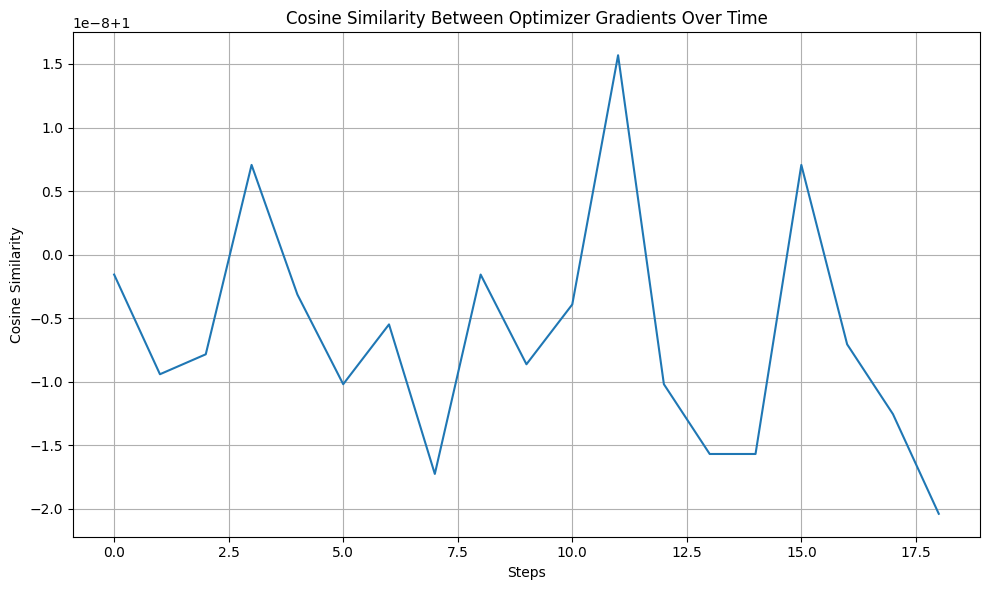

In [5]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer, AdamW
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F  # For cosine similarity calculation

# Configuration dictionary
cfg = {
    "model_name": "EleutherAI/pythia-70m",  # Using pythia-70m
    "learning_rate": 1e-4,
    "training_batch_size": 1,
    "inference_batch_size": 200,
    "num_train_epochs": 1,
    "max_length": 128,
    "repeat_loops": 10,  # 10 repeat loops
    "experiment_name": "loop_training_experiment_cosine",
    "qa_data_file": "/workspace/slice-monorepo/sub_validations/episodic_memory_paper/qa_data.json",
    "pile_data_file": "/workspace/slice-monorepo/sub_validations/unique_seq_sentence/detokenized_output.json",
    "inference_params": {
        "max_new_tokens": 50,
        "temperature": 0.7,
        "top_k": 50,
        "do_sample": True,
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Create experiment folder
def create_experiment_folder(cfg):
    experiment_folder = f"experiments/{cfg['experiment_name']}"
    os.makedirs(experiment_folder, exist_ok=True)
    return experiment_folder

# Batch saving of CSV data using Pandas
class CSVLogger:
    def __init__(self, file_path, columns):
        self.file_path = file_path
        self.columns = columns
        self.buffer = []

    def log(self, row):
        self.buffer.append(row)

    def flush(self):
        if self.buffer:
            df = pd.DataFrame(self.buffer, columns=self.columns)
            if not os.path.exists(self.file_path):
                df.to_csv(self.file_path, mode='w', header=True, index=False)
            else:
                df.to_csv(self.file_path, mode='a', header=False, index=False)
            self.buffer = []

# Save the configuration to the experiment folder
def save_config(cfg, experiment_folder):
    config_path = os.path.join(experiment_folder, "config.json")
    with open(config_path, 'w') as config_file:
        json.dump(cfg, config_file, indent=4)

# Loop class to store loop data
class Loop:
    def __init__(self, loop_id, pile_data, qa_data, optimizer_state=None):
        self.loop_id = loop_id
        self.pile_data = pile_data  # List of texts
        self.qa_data = qa_data  # {'question', 'answer'}
        self.optimizer_state = optimizer_state  # Optimizer state dict

# Custom Dataset for Loop data
class LoopDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts  # List of texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokenized = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': tokenized['input_ids'].squeeze(),
            'attention_mask': tokenized['attention_mask'].squeeze(),
            'labels': tokenized['input_ids'].squeeze()
        }

class Trainer:
    def __init__(self, cfg, tokenizer, model, experiment_folder):
        self.cfg = cfg
        self.tokenizer = tokenizer
        self.device = cfg['device']
        self.model = model.to(self.device)
        self.experiment_folder = experiment_folder

        self.training_loss_logger = CSVLogger(
            os.path.join(experiment_folder, "training_loss.csv"),
            ["Training Loop ID", "Loop Repeat", "Step", "Loss"]
        )
        self.inference_results_logger = CSVLogger(
            os.path.join(experiment_folder, "inference_results.csv"),
            ["Loop ID", "Step", "Question", "Answer", "Correct", "Raw Output", "Inference Identifier"]
        )

        # Track cosine similarities at the beginning of loops
        self.cosine_similarities = []
        self.previous_optimizer_state = None  # To store the previous optimizer state

    def compute_cosine_similarity(self, optimizer1, optimizer2):
        """Compute the cosine similarity between gradients of two optimizers."""
        grads1 = [param.grad for param in optimizer1.param_groups[0]['params'] if param.grad is not None]
        grads2 = [param.grad for param in optimizer2.param_groups[0]['params'] if param.grad is not None]

        cos_sims = []
        for g1_param, g2_param in zip(grads1, grads2):
            g1_flat = g1_param.view(-1)
            g2_flat = g2_param.view(-1)
            cos_sim = F.cosine_similarity(g1_flat, g2_flat, dim=0).item()
            cos_sims.append(cos_sim)
        
        avg_cos_sim = np.mean(cos_sims)
        return avg_cos_sim

    def plot_cosine_similarity(self):
        """Plot cosine similarity after training is complete."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.cosine_similarities)
        plt.xlabel('Steps')
        plt.ylabel('Cosine Similarity')
        plt.title('Cosine Similarity Between Optimizer Gradients Over Time')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.experiment_folder, 'cosine_similarity_plot.png'))
        plt.show()

    def train_loop(self, loop, other_loop, loop_repeat, train_on_qa):
        """Train a loop and compare the optimizer's gradient similarity at the beginning of the loop."""
        optimizer1 = AdamW(self.model.parameters(), lr=self.cfg['learning_rate'])

        # Compare the optimizer state at the start of the loop to the previous loop's final state
        if self.previous_optimizer_state is not None:
            optimizer2 = AdamW(self.model.parameters(), lr=self.cfg['learning_rate'])
            optimizer2.load_state_dict(self.previous_optimizer_state)
            cos_sim = self.compute_cosine_similarity(optimizer1, optimizer2)
            self.cosine_similarities.append(cos_sim)
            print(f"Cosine similarity at start of loop {loop.loop_id}: {cos_sim}")

        # Train the loop
        dataset = LoopDataset(loop.pile_data, self.tokenizer, max_length=self.cfg['max_length'])
        dataloader = DataLoader(dataset, batch_size=self.cfg['training_batch_size'], shuffle=False)

        steps = 0

        self.model.train()
        for epoch in range(self.cfg['num_train_epochs']):
            for step_idx, batch in enumerate(dataloader, start=1):
                optimizer1.zero_grad()

                inputs = {key: val.to(self.device) for key, val in batch.items()}
                outputs = self.model(**inputs)
                loss = outputs.loss
                loss.backward()
                optimizer1.step()

                steps += 1
                self.training_loss_logger.log([loop.loop_id, loop_repeat + 1, steps, loss.item()])

        # Save the current optimizer state for future comparison at the end of the loop
        loop.optimizer_state = optimizer1.state_dict()
        self.previous_optimizer_state = optimizer1.state_dict()  # Save for the next loop

        self.training_loss_logger.flush()
        self.inference_results_logger.flush()

def main():
    tokenizer = AutoTokenizer.from_pretrained(cfg['model_name'])
    tokenizer.padding_side = 'left'  # Set padding side to left for decoder-only architecture

    model = GPTNeoXForCausalLM.from_pretrained(
        cfg['model_name'],
        pad_token_id=tokenizer.eos_token_id
    )
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))

    with open(cfg['qa_data_file'], 'r') as f:
        qa_data_json = json.load(f)

    with open(cfg['pile_data_file'], 'r') as f:
        pile_data = json.load(f)

    loops = []
    for loop_id in range(2):
        pile_start = loop_id * 100
        pile_end = pile_start + 100
        pile_data_loop = pile_data[pile_start:pile_end]

        qa_question = qa_data_json['qa_data']['question'][loop_id]
        qa_answer = qa_data_json['qa_data']['answer'][loop_id]
        qa_data = {'question': qa_question, 'answer': qa_answer}

        loop = Loop(loop_id, pile_data_loop, qa_data)
        loops.append(loop)

    experiment_folder = create_experiment_folder(cfg)
    save_config(cfg, experiment_folder)

    trainer = Trainer(cfg, tokenizer, model, experiment_folder)

    # Loop structure with comparisons at the start of each loop
    for repeat_idx in range(cfg['repeat_loops']):
        train_on_qa = repeat_idx < (cfg['repeat_loops'] // 2)

        for i in range(len(loops)):
            current_loop = loops[i]
            other_loop = loops[1 - i]  # The other loop
            trainer.train_loop(current_loop, other_loop, repeat_idx, train_on_qa)

    trainer.plot_cosine_similarity()

if __name__ == "__main__":
    main()
